In [1]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters 

In [21]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [2]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_best_result, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

## Load and Preprocess Data

In [3]:
dataset = 'MNIST'
learner_type = 'KNN'
loader_func = load_mnist

In [4]:
df = loader_func(preprocess=True)

Target column encoded with the following classes [ 4.  9.]
Dataset shape (13782, 785)
Value composition:
1    0.504861
0    0.495139
Name: target, dtype: float64


/home/jovyan/loaders.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_df['target'] = le.fit_transform(filtered_df['target'])


### Split data into training and testing

In [5]:
X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [6]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN Model Selection

In [7]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

In [8]:
param_grid = {
    'n_neighbors': range(1, 16),
    'weights': ['uniform', 'distance']
}

In [11]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True,
    cv=4,
    verbose=1,
    n_jobs=-1,
)

In [12]:
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 38 candidates, totalling 152 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed: 64.6min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 100], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [13]:
save_search_result(grid_search, dataset, learner_type)

### Analysis

In [9]:
# res = grid_search.cv_results_
res = load_best_result(dataset, learner_type)
res_df = scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score').head(10)

Found the following results files for this dataset/algorithm: ['0.984_MNIST_KNN_2018-09-12_22:48-04:00.pkl', '0.984_MNIST_KNN_2018-09-18_11-06-04-00.pkl', '0.982_MNIST_KNN_2018-09-13T01:35.pkl']
Returning results for the highest-scoring-file: 0.984_MNIST_KNN_2018-09-18_11-06-04-00.pkl


mean_fit_time  std_fit_time  mean_score_time  \
n_neighbors weights                                                  
8           uniform        0.651777      0.050609        25.279838   
6           uniform        0.635321      0.086893        26.470993   
8           distance       0.614231      0.021032        25.069893   
4           uniform        0.684417      0.048673        26.212616   
10          uniform        0.608483      0.016975        24.922951   
            distance       0.651395      0.035768        24.827111   
12          distance       0.697442      0.076189        25.928428   
7           distance       0.616309      0.041514        25.298478   
            uniform        0.626540      0.040059        25.316354   
12          uniform        0.764706      0.137073        25.257586   

                      std_score_time  mean_test_score  std_test_score  \
n_neighbors weights                                                     
8           uniform         0.073022         0.983829        0.002248   
6           uniform         0.079396         0.983311        0.002558   
8           distance        0.058210         0.983207        0.002560   
4           uniform         0.049969         0.983104        0.004259   
10          uniform         0.183437         0.982793        0.003078   
            distance        0.032615         0.982689        0.002384   
12          distance        0.045965         0.982585        0.002247   
7           distance        0.029552         0.982482        0.002859   
            uniform         0.056308         0.982482        0.002859   
12          uniform         0.030313         0.982274        0.002592   

                      rank_test_score  mean_train_score  std_train_score  
n_neighbors weights                                                       
8           uniform                 1          0.987734         0.000396  
6           uniform                 2          0.988736         0.000694  
8           distance                3          1.000000         0.000000  
4           uniform                 4          0.990844         0.001546  
10          uniform                 5          0.987457         0.000914  
            distance                6          1.000000         0.000000  
12          distance                7          1.000000         0.000000  
7           distance                8          1.000000         0.000000  
            uniform                 8          0.987181         0.000614  
12          uniform                10          0.986213         0.000680

In [10]:
# Drop k values greater than 15
res_df = res_df.loc[slice(15)]

In [14]:
distance = res_df.xs('distance', level='weights')
uniform = res_df.xs('uniform', level='weights')
np.unique(res_df.index.get_level_values('n_neighbors'))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

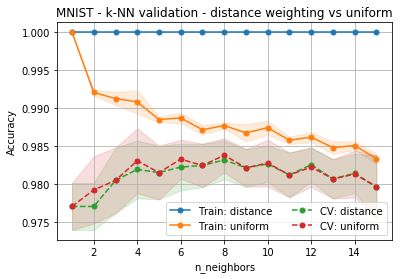

In [15]:
plot_means_w_stds(
    means=(distance['mean_train_score'], uniform['mean_train_score'], distance['mean_test_score'], uniform['mean_test_score']),
    stds=(distance['std_train_score'], uniform['std_train_score'], distance['std_test_score'], uniform['std_test_score']),
    xrange=param_grid['n_neighbors'],
    xlabel='n_neighbors',
    ylabel='Accuracy',
    series_labels=('Train: distance', 'Train: uniform', 'CV: distance', 'CV: uniform'),
    title='MNIST - k-NN validation - distance weighting vs uniform',
    legend_kwargs={'loc': 'best', 'ncol': 2}
)

### Timing Analysis

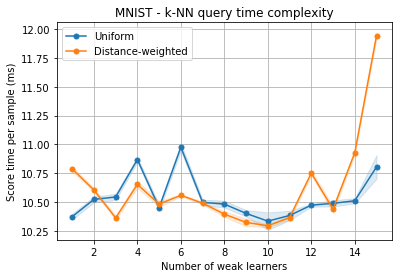

In [18]:
means = [uniform['mean_score_time'], distance['mean_score_time']]
stds = [uniform['std_score_time'], distance['std_score_time']]
labels = ['Uniform', 'Distance-weighted']

# Calculate per-sample mean
n_samples = X_train_scaled.shape[0] / 4 # one quarter of dataset was scored for 4-fold validation
means_per_samp = [mean / n_samples * 1000 for mean in means]
stds_per_samp = [std / n_samples * 1000 for std in stds]

plot_means_w_stds(
    means_per_samp,
    stds_per_samp,
    param_grid['n_neighbors'],
    series_labels=labels,
    title='MNIST - k-NN query time complexity',
    legend_kwargs={'loc': 'best'},
    ylabel='Score time per sample (ms)',
    xlabel='Number of weak learners',
    linestyles=['-']*2,
#     fig_kwargs={'figsize': (10,6)},
)

## kNN Learning Curve Analysis

In [24]:
best_params = res['params'][np.argmax(res['mean_test_score'])]
clf = KNeighborsClassifier(**best_params)
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'uniform'}

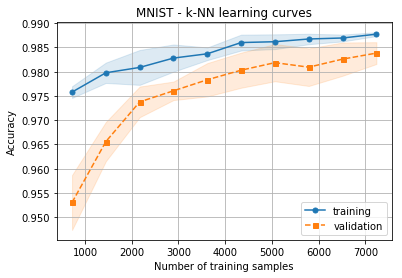

In [25]:
train_sizes, train_scores, test_scores, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylim=None, cv=4, n_jobs=-1, title='MNIST - k-NN learning curves')

# Performance on Test Set

In [26]:
best_clf = KNeighborsClassifier(**best_params)

best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = accuracy_score(y_test, y_test_pred)
print('%.4f' % test_score)

0.9848
